In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_locations
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
NUMBER_OF_NEARBY_LOCATIONS = 3

# select a location and the four closest to it
nearby_locations = load_nearby_locations(some_airlocation_ids[20], 50)[0:NUMBER_OF_NEARBY_LOCATIONS]

print("Predicting for: " + load_air_location_data(nearby_locations[0][0])['en_city_name'])
print("Using nearby locations: " + str([load_air_location_data(l[0])["short_name"] for l in nearby_locations[1:]]))

Predicting for: Chengdu Shi
Using nearby locations: ['China/成都/沙河铺', 'China/成都/三瓦窑']


In [3]:
loc_columns_format = ['loc_{}_id', 'loc_{}_measurement_datetime', 'loc_{}_aqi']

def initial_load_and_format_airlocation(airlocation_id, index):
    single_loc_df = load_measurement_data(airlocation_id)
    single_loc_df.columns = [c.format(index) for c in loc_columns_format]
    print("{} rows loaded for loc #{}".format(single_loc_df.count()[0], airlocation_id))
    return single_loc_df

dfs = [initial_load_and_format_airlocation(nearby_locations[0][0], 1)]

for index, location in enumerate(nearby_locations[1:]):
    loc_df = initial_load_and_format_airlocation(location[0], index + 2)
    dfs.append(loc_df)

36037 rows loaded for loc #964


37522 rows loaded for loc #802


37535 rows loaded for loc #633


In [4]:
from predict_aqi.transform_data import align_multi_location_time_series_data
import datetime

start = datetime.datetime.now()
df, continuous_time_series = align_multi_location_time_series_data(dfs, NUMBER_OF_NEARBY_LOCATIONS)
end = datetime.datetime.now()

In [5]:
print("Cleaning data took {} seconds".format((end - start).total_seconds()))

Cleaning data took 134.983078 seconds


In [6]:
print(continuous_time_series)

[(0, 589), (589, 590), (590, 658), (658, 1139), (1139, 1153), (1153, 1606), (1606, 2591), (2591, 2929), (2929, 8354), (8354, 9938), (9938, 11503), (11503, 19617), (19617, 23147), (23147, 23263), (23263, 23282), (23282, 25218), (25218, 26177), (26177, 26920), (26920, 27380), (27380, 28099), (28099, 29043), (29043, 30773), (30773, 30941), (30941, 34333), (34333, 34909), (34909, 34965), (34965, 34997), (34997, 35658), (35658, 35868)]


[0.0, 120000000.0, 0.0, 300.0]

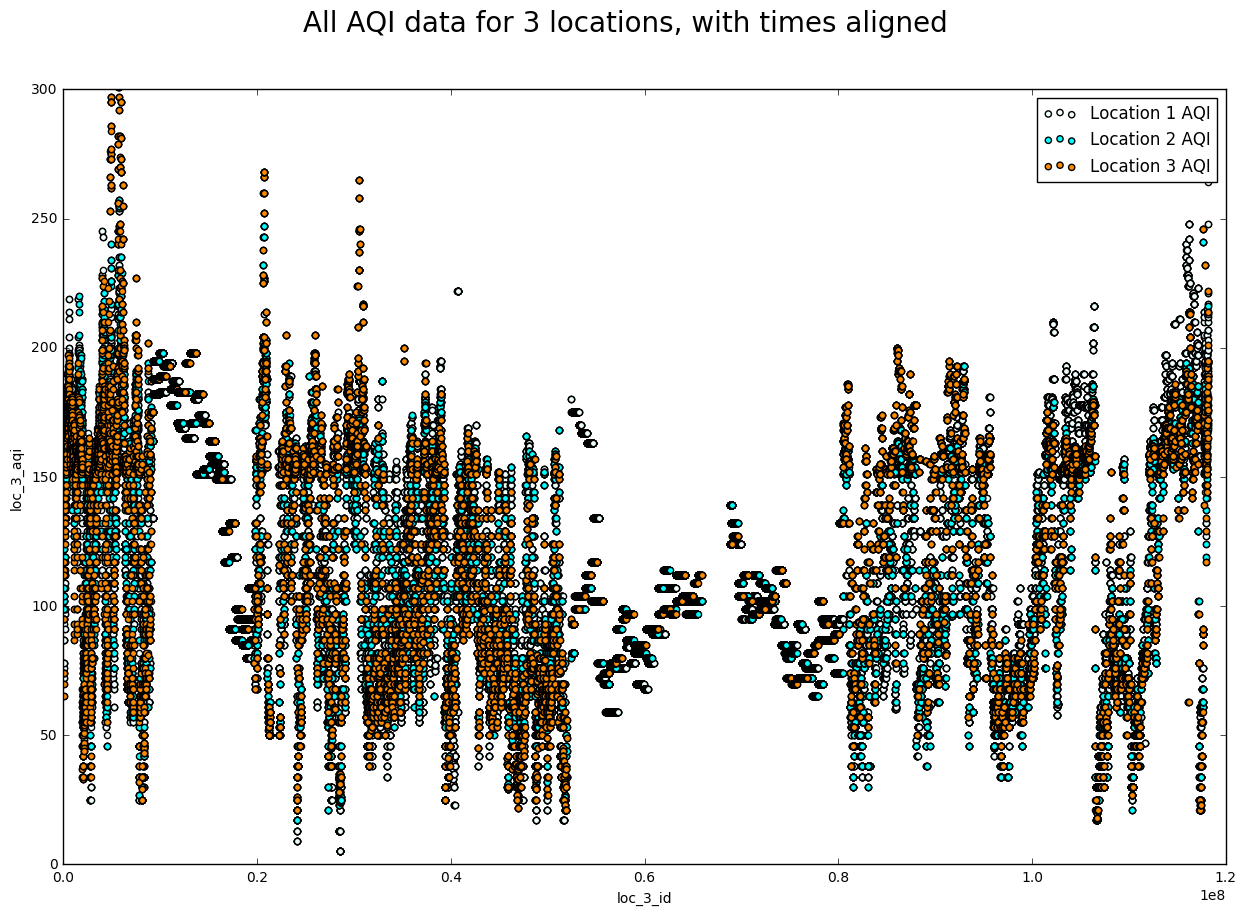

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
colours = sorted(list(cnames.keys()))
aqi_graph = df.plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df.plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("All AQI data for {} locations, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [23]:
# Select classifier to use
from predict_aqi.multi_city_model import generate_AQI_inputs_and_outputs
from predict_aqi import config
from predict_aqi.transform_data import clean_data, generate_time_inputs

MAX_INDEX = 48
INDICES_AHEAD_TO_PREDICT = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 4)
LAST_INDEX_BEHIND_TO_USE = 24
indices_behind_to_use = range(LAST_INDEX_BEHIND_TO_USE + 1)
locations = ['loc_{}'.format(str(i)) for i in range(1, NUMBER_OF_NEARBY_LOCATIONS + 1)]

df, continuous_time_series, input_columns, output_columns = generate_AQI_inputs_and_outputs(
    df, continuous_time_series, INDICES_AHEAD_TO_PREDICT, indices_behind_to_use, NUMBER_OF_NEARBY_LOCATIONS
)

df = clean_data(df, output_columns, input_columns, remove_dirty=True)

/home/jovyan/work/predict_aqi/transform_data.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_df['is_dirty'] = new_df[output_columns].apply(lambda x: any(map(np.isnan, x)), axis=1)


In [24]:
print(df.shape)
print(input_columns)
print(output_columns)

(21226, 108)
['minute_of_day_sin', 'minute_of_day_cos', 'day_of_year_cos', 'day_of_year_sin', 'day_of_week_cos', 'day_of_week_sin', 'day_of_month_sin', 'day_of_month_cos', '0_ago_loc_1', '1_ago_loc_1', '2_ago_loc_1', '3_ago_loc_1', '4_ago_loc_1', '5_ago_loc_1', '6_ago_loc_1', '7_ago_loc_1', '8_ago_loc_1', '9_ago_loc_1', '10_ago_loc_1', '11_ago_loc_1', '12_ago_loc_1', '13_ago_loc_1', '14_ago_loc_1', '15_ago_loc_1', '16_ago_loc_1', '17_ago_loc_1', '18_ago_loc_1', '19_ago_loc_1', '20_ago_loc_1', '21_ago_loc_1', '22_ago_loc_1', '23_ago_loc_1', '24_ago_loc_1', '0_ago_loc_2', '1_ago_loc_2', '2_ago_loc_2', '3_ago_loc_2', '4_ago_loc_2', '5_ago_loc_2', '6_ago_loc_2', '7_ago_loc_2', '8_ago_loc_2', '9_ago_loc_2', '10_ago_loc_2', '11_ago_loc_2', '12_ago_loc_2', '13_ago_loc_2', '14_ago_loc_2', '15_ago_loc_2', '16_ago_loc_2', '17_ago_loc_2', '18_ago_loc_2', '19_ago_loc_2', '20_ago_loc_2', '21_ago_loc_2', '22_ago_loc_2', '23_ago_loc_2', '24_ago_loc_2', '0_ago_loc_3', '1_ago_loc_3', '2_ago_loc_3', '3_

[0.0, 120000000.0, 0.0, 300.0]

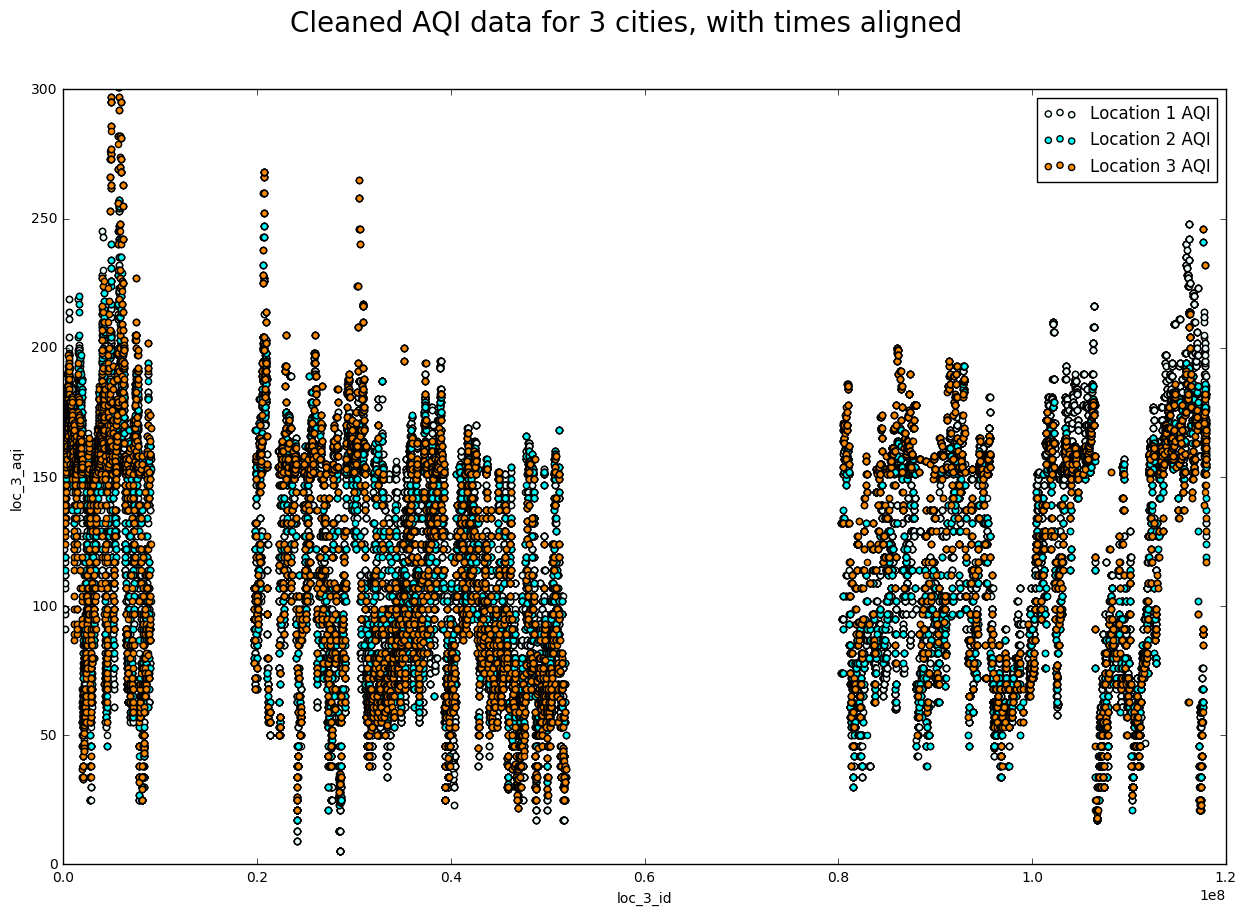

In [25]:
aqi_graph = df[df['is_dirty'] == False].plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df.plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("Cleaned AQI data for {} cities, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from predict_aqi.predictor_utils import train_regressor, predict_values
from predict_aqi.transform_data import (
    generate_time_inputs, shift_and_save_column, clean_data
)

'''
Rows that are learned on meet the following criteria:
* All the locations have a valid AQI value within 10 minutes of each other (align_multi_location_time_series_data method)
* There are at least 3 different AQI values for the target location in the next 48 rows (clean_data method)
* The next 48 rows from any given valid row are in series, ~30 minutes apart
'''
def generate_predictions(
        df,
        continuous_time_series,
        input_columns,
        output_columns,
        split_function,
        regressors,
        print_progress,
        prediction_column_suffix='_ahead_pred'):
    # x_train, y_train, x_test, y_test = split_function(
    #     df, input_columns, output_columns
    # )
    
    # Train regressors
    assert len(output_columns) == len(regressors)
    df_training_data = split_function(df)
    for output_column, regressor in zip(output_columns, regressors):
        train_regressor(
            regressor, 
            df_training_data[input_columns], 
            df_training_data[output_column], 
            print_progress
        )
                
    # Make predictions
    for output_column, regressor in zip(output_columns, regressors):
        predictions = predict_values(regressor, df[input_columns], print_progress)
        predictions_df = pd.DataFrame(predictions, index=df.index)
        prediction_columns = [output_column.replace('_ahead_AQI', prediction_column_suffix)]
        predictions_df.columns = prediction_columns
        df = df.join(predictions_df)
    
    return df


def generate_predictions_two_step(all_data,
                                  additional_second_step_features,
                                  output_columns,
                                  split_function,
                                  first_step_locations,
                                  first_step_regressors,
                                  second_step_regressors,
                                  indices_ahead_to_predict,
                                  indices_behind_to_use,
                                  prediction_column_suffix,
                                  print_progress=True,
                                  ):

    if print_progress:
        print("Step 1")
    
    # make a regressor + predictions for each location
    for location, regressor in zip(first_step_locations, first_step_regressors):
        # the feature columns depend on the city, but they are all
        # trying to predict the AQI of the target city
        feature_columns = ["{}_ago_{}".format(i, location) 
                           for i in indices_behind_to_use]
        # print(feature_columns)
        x_train, y_train, x_test, y_test = split_function(
            all_data, feature_columns, output_columns
        )
        train_regressor(regressor, x_train, y_train, print_progress)
    
        # Make the first step predictions and merge them into the all_data dataframe
        first_step_predictions = predict_values(regressor, all_data[feature_columns], print_progress)
        first_step_predictions_df = pd.DataFrame(first_step_predictions, index=all_data.index)
        prediction_columns = ['{}_ahead_{}_first_step_pred'.format(str(i), location) 
                              for i in indices_ahead_to_predict]
        first_step_predictions_df.columns = prediction_columns
        all_data = all_data.join(first_step_predictions_df)

    if print_progress:
        print("Step 2")

    # make a regressor + predictions for each "x hours ahead" we want to predict
    for index_ahead_to_predict, output_column, regressor in zip(indices_ahead_to_predict, output_columns, second_step_regressors):
        # Use only the prediction from the first step that corresponds to this step's regressor, otherwise
        # it will overfit using all the first step prediction values.
        second_step_input_columns_from_first = ['{}_ahead_{}_first_step_pred'.format(index_ahead_to_predict, location)
                                                for location in first_step_locations]
        feature_columns = list(itertools.chain(
            additional_second_step_features, second_step_input_columns_from_first
        ))

        x_train, y_train, x_test, y_test = split_function(
            all_data, feature_columns, [output_column]
        )
        train_regressor(regressor, x_train, y_train, print_progress)

        # Make the second step predictions and merge them into the all_data dataframe
        second_step_predictions = predict_values(
            regressor, all_data[feature_columns], print_progress
        )
        second_step_predictions_df = pd.DataFrame(second_step_predictions, index=all_data.index)
        prediction_columns = ['{}_{}'.format(str(index_ahead_to_predict), prediction_column_suffix)]
        second_step_predictions_df.columns = prediction_columns
        all_data = all_data.join(second_step_predictions_df)

    return all_data


def generate_baseline_predictions(df, output_columns, source_column='loc_1_aqi'):
    for output_column in output_columns:
        prediction_column_name = output_column.replace('_ahead_AQI', '_ahead_baseline_pred') 
        df[prediction_column_name] = df[source_column]
    return df
    

row_count = df.count()[0]
split_row = int(round(row_count * 0.90))

# returns the data frame up to the split row
# iloc uses row index after filtering as if a re-indexing occurred (as opposed to using the indexing
# that existed before the dirty data filtering happened)
def cut_off_end_split_function(all_data, input_columns, output_columns, cut_off_percentage=0.9):
    # Split by the first 90% of data. That means our testing set is extrapolation.
    row_count = all_data.count()[0]
    split_row = int(round(row_count * cut_off_percentage))
    # x_train, y_train, x_test, y_test
    return (all_data[input_columns].iloc[:split_row],
            all_data[output_columns].iloc[:split_row],
            all_data[input_columns].iloc[split_row:],
            all_data[output_columns].iloc[split_row:])


df, second_step_additional_features = generate_time_inputs(df, time_column="loc_1_measurement_datetime")

output_columns = ["{}_ahead_AQI".format(str(i)) for i in INDICES_AHEAD_TO_PREDICT]


# Make baseline predictions
baseline_df = df.copy(deep=True)
baseline_df = generate_baseline_predictions(baseline_df, output_columns)

# Make predictions with 1 city
# make regressors for each index ahead to predict
locations = ['loc_1']
first_step_regressors = [MLPRegressor() for i in locations]
second_step_regressors = [MLPRegressor() for i in INDICES_AHEAD_TO_PREDICT]


# generate predictions
single_city_df = df.copy(deep=True)
single_city_df = generate_predictions_two_step(
    single_city_df,
    second_step_additional_features,
    output_columns,
    cut_off_end_split_function,
    locations,
    first_step_regressors,
    second_step_regressors,
    INDICES_AHEAD_TO_PREDICT,
    indices_behind_to_use,
    "ahead_single_city_pred",
    False
)

# Make predictions with 3 cities
# make regressors for each index ahead to predict
locations = ['loc_1', 'loc_2', 'loc_3']
first_step_regressors = [MLPRegressor() for i in locations]
second_step_regressors = [MLPRegressor() for i in INDICES_AHEAD_TO_PREDICT]

three_city_df = df.copy(deep=True)
three_city_df = generate_predictions_two_step(
    three_city_df,
    second_step_additional_features,
    output_columns,
    cut_off_end_split_function,
    locations,
    first_step_regressors,
    second_step_regressors,
    INDICES_AHEAD_TO_PREDICT,
    indices_behind_to_use,
    "ahead_three_city_pred",
    False
)


/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
print(list(three_city_df.columns))

['loc_1_id', 'loc_1_measurement_datetime', 'loc_1_aqi', 'loc_2_id', 'loc_2_measurement_datetime', 'loc_2_aqi', 'loc_3_id', 'loc_3_measurement_datetime', 'loc_3_aqi', 'loc_1_normalized_AQI', 'loc_2_normalized_AQI', 'loc_3_normalized_AQI', '2_ahead_AQI', '18_ahead_AQI', '34_ahead_AQI', 'minute_of_day_sin', 'minute_of_day_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos', '0_ago_loc_1', '1_ago_loc_1', '2_ago_loc_1', '3_ago_loc_1', '4_ago_loc_1', '5_ago_loc_1', '6_ago_loc_1', '7_ago_loc_1', '8_ago_loc_1', '9_ago_loc_1', '10_ago_loc_1', '11_ago_loc_1', '12_ago_loc_1', '13_ago_loc_1', '14_ago_loc_1', '15_ago_loc_1', '16_ago_loc_1', '17_ago_loc_1', '18_ago_loc_1', '19_ago_loc_1', '20_ago_loc_1', '21_ago_loc_1', '22_ago_loc_1', '23_ago_loc_1', '24_ago_loc_1', '0_ago_loc_2', '1_ago_loc_2', '2_ago_loc_2', '3_ago_loc_2', '4_ago_loc_2', '5_ago_loc_2', '6_ago_loc_2', '7_ago_loc_2', '8_ago_loc_2', '9_ago_loc_2', '10_ago_loc_2', '

In [28]:
errors = {
    'single_city_pred': {}, 
    'three_city_pred': {}, 
    'baseline_pred': {}, 
    'first_city_pred': {}, 
    'second_city_pred': {},
    'third_city_pred': {}
}
for i in INDICES_AHEAD_TO_PREDICT:
    actual_column = '{}_ahead_AQI'.format(i)
    three_city_pred_column = '{}_ahead_three_city_pred'.format(i)
    first_city_pred_column = '{}_ahead_loc_1_first_step_pred'.format(i)
    second_city_pred_column = '{}_ahead_loc_2_first_step_pred'.format(i)
    third_city_pred_column = '{}_ahead_loc_3_first_step_pred'.format(i)
    single_city_pred_column = '{}_ahead_single_city_pred'.format(i)
    baseline_pred_column = '{}_ahead_baseline_pred'.format(i)
    
    single_city_df[single_city_pred_column] = single_city_df[single_city_pred_column].apply(lambda x: x * 300)
    three_city_df[three_city_pred_column] = three_city_df[three_city_pred_column].apply(lambda x: x * 300)
    three_city_df[first_city_pred_column] = three_city_df[first_city_pred_column].apply(lambda x: x * 300)
    three_city_df[second_city_pred_column] = three_city_df[second_city_pred_column].apply(lambda x: x * 300)
    three_city_df[third_city_pred_column] = three_city_df[third_city_pred_column].apply(lambda x: x * 300)
    single_city_df[actual_column] = single_city_df[actual_column].apply(lambda x: x * 300)
    
    errors['single_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        single_city_df[single_city_pred_column]
    )
    errors['three_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[three_city_pred_column]
    )
    errors['first_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[first_city_pred_column]
    )
    errors['second_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[second_city_pred_column]
    )
    errors['third_city_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        three_city_df[third_city_pred_column]
    )
    errors['baseline_pred'][i] = mean_absolute_error(
        single_city_df[actual_column], 
        baseline_df[baseline_pred_column]
    )

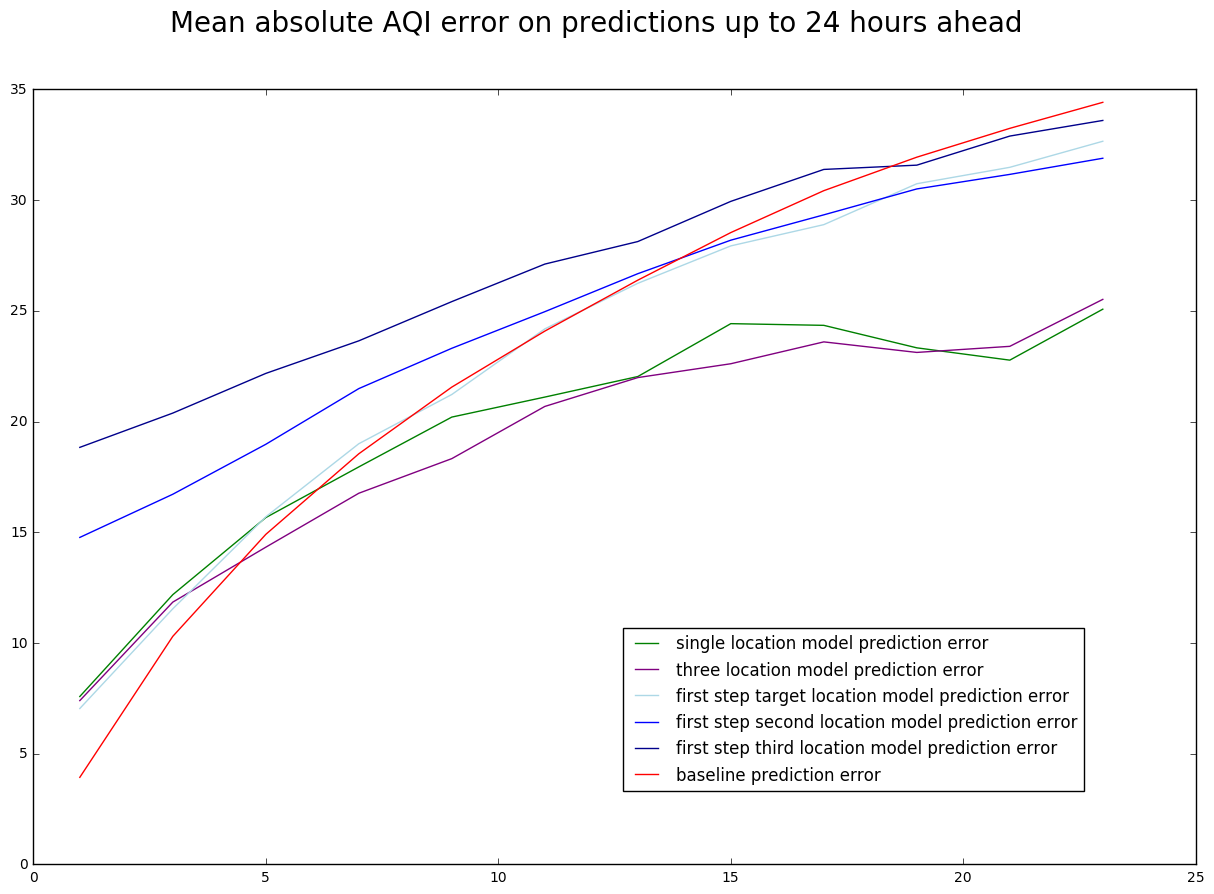

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.axis([0.0, 25.0, 0.0, 35.0])
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['single_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="single location model prediction error",
    color="Green"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['three_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="three location model prediction error",
    color="Purple"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['first_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step target location model prediction error",
    color="LightBlue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['second_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step second location model prediction error",
    color="Blue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['third_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="first step third location model prediction error",
    color="DarkBlue"
)
plt.plot(
    [h // 2 for h in INDICES_AHEAD_TO_PREDICT],
    [errors['baseline_pred'][i] for i in INDICES_AHEAD_TO_PREDICT], 
    label="baseline prediction error",
    color="Red"
)
plt.legend(loc=6, bbox_to_anchor=(0.5, 0.2))
plt.suptitle("Mean absolute AQI error on predictions up to 24 hours ahead", fontsize=20)

In [32]:
print("The average of each hour ahead's average absolute error (of the 24 different hours ahead predicted).")
print("Baseline error : {}".format(sum([errors['baseline_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))
print("Three city model error: {}".format(sum([errors['three_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))
print("Single city model error: {}".format(sum([errors['single_city_pred'][i] for i in INDICES_AHEAD_TO_PREDICT])))

The average of each hour ahead's average absolute error (of the 24 different hours ahead predicted).
Baseline error : 278.28512202016395
Three city model error: 229.59026834150472
Single city model error: 236.6827633009371
